In [1]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import seaborn as sns

matplotlib.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', 100)

## DataFrame of Image Paths, Labels, and Bounding Boxes

Images of U.S. passenger vehicles by make, model, year, and category (e.g. car, pickup, van) were obtained by scraping Google Images using the script `./create_training_images/scrape_vehicle_make_models.py`. This scraped the first 100 images, saving these locally. The list of vehicle makes and models was obtained from the [back4app.com](https://www.back4app.com/database/back4app/car-make-model-dataset) database, including all vehicles present in U.S. market starting in the year 2000. An analysis of this database can be found under `./create_training_images/back4app_database_analysis.ipynb`. In this notebook, we compare scraped image results to the back4app.com database.

The images referenced in the Pandas DataFrame `df` below have all been unduplicated by URL. Approximately 11% of scraped images were from a duplicate URL (i.e. the same image was present more than once within the same scraping query or across different queries) or were missing URL information. Images with a duplicate or missing URL were deleted from this DataFrame.

In [2]:
df = pd.read_csv('/Users/josephking/Documents/sponsored_projects/MERGEN/data/vehicle_classifier/data_directories/MakeModelDirectory_Bboxes.csv')

In [3]:
df.head()

Make Model Category                   Source Path  \
0  Acura    CL      Car  Acura/CL/2001/f04ed53e11.jpg   
1  Acura    CL      Car  Acura/CL/2001/6084dddd71.jpg   
2  Acura    CL      Car  Acura/CL/2001/723a443ab2.jpg   
3  Acura    CL      Car  Acura/CL/2001/cb6d1e23cb.jpg   
4  Acura    CL      Car  Acura/CL/2001/ede0361fca.jpg   

                                                 URL  \
0  https://encrypted-tbn0.gstatic.com/images?q=tb...   
1  https://encrypted-tbn0.gstatic.com/images?q=tb...   
2  https://encrypted-tbn0.gstatic.com/images?q=tb...   
3  https://www.carspecs.us/photos/7d756cd1c893894...   
4  https://encrypted-tbn0.gstatic.com/images?q=tb...   

                                             Bboxes  
0     [12.0, 54.0, 255.0, 134.0, 0.745485246181488]  
1     [0.0, 56.0, 243.0, 157.0, 0.6771612167358398]  
2    [13.0, 45.0, 242.0, 156.0, 0.6907992959022522]  
3  [34.0, 156.0, 1764.0, 914.0, 0.7766640782356262]  
4    [41.0, 59.0, 253.0, 139.0, 0.8391361832618713]

In [4]:
df.shape

(733435, 6)

### Make Model Database

In [5]:
db = pd.read_csv('make_model_database_mod.csv')

### Verify Completeness of Vehicle Make

In [6]:
df.Make.unique()

array(['Acura', 'Alfa Romeo', 'Aston Martin', 'Audi', 'BMW', 'Bentley',
       'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge',
       'Ferrari', 'Fiat', 'Ford', 'GMC', 'Genesis', 'HUMMER', 'Honda',
       'Hyundai', 'INFINITI', 'Isuzu', 'Jaguar', 'Jeep', 'Kia',
       'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'Lotus', 'MINI',
       'Maserati', 'Maybach', 'Mazda', 'McLaren', 'Mercedes-Benz',
       'Mercury', 'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth',
       'Pontiac', 'Porsche', 'RAM', 'Rolls-Royce', 'Saab', 'Saturn',
       'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen',
       'Volvo', 'smart'], dtype=object)

In [7]:
# Verify no makes missing
assert(len([i for i in db.Make.unique() if i not in df.Make.unique()]) == 0)

### Verify Completeness of Make-Model

In [8]:
merged = db[['Make', 'Model']].drop_duplicates().merge(df[['Make', 'Model']].drop_duplicates(), indicator=True)

In [9]:
assert((merged._merge == 'both').all())

# Image Counts per Make-Model

The following examines the number of scraped images per vehicle make-model combination, regardless of whether that particular image has an associated YOLOv5 bounding box.

In [10]:
make_model = pd.DataFrame((df['Make'] + ' ' + df['Model']), columns=['Make_Model'])
make_model['Count'] = 1
make_model = make_model.groupby('Make_Model')['Count'].count().reset_index()

In [11]:
make_model['Count'].describe()

count      654.000000
mean      1121.460245
std       1326.313469
min         81.000000
25%        351.500000
50%        681.000000
75%       1413.000000
max      12122.000000
Name: Count, dtype: float64

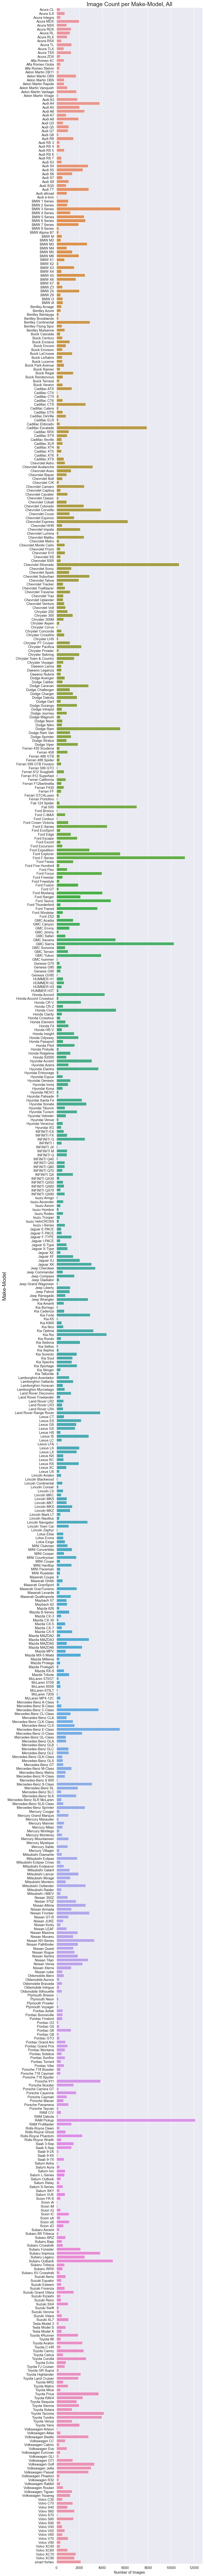

In [12]:
figure(figsize=(10, 180), dpi=80)
sns.set(font_scale=1.2)
sns.barplot(data=make_model, x='Count', y='Make_Model')
plt.xlabel("Number of Images")
plt.ylabel("Make-Model", fontsize=20)
plt.title("Image Count per Make-Model, All", fontsize=22)
plt.show()

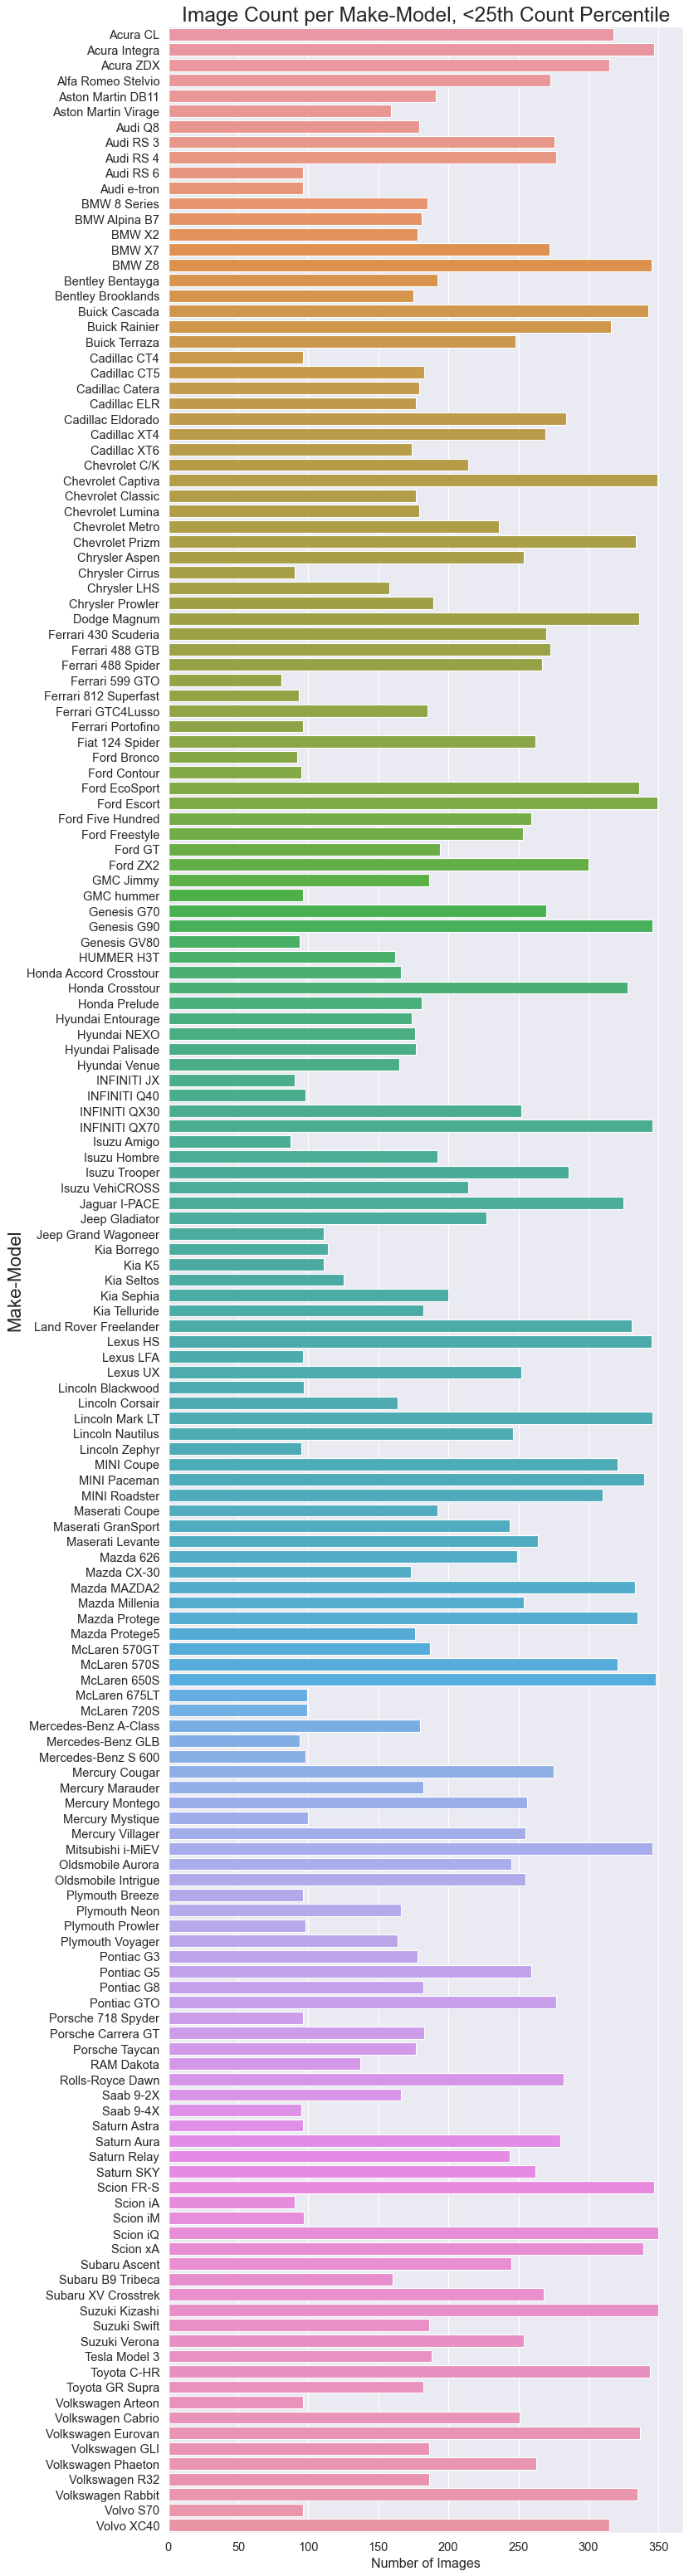

In [13]:
figure(figsize=(10, 50), dpi=80)
sns.set(font_scale=1.2)
sns.barplot(data=make_model.loc[make_model['Count'] < 351], x='Count', y='Make_Model')
plt.xlabel("Number of Images")
plt.ylabel("Make-Model", fontsize=20)
plt.title("Image Count per Make-Model, <25th Count Percentile", fontsize=22)
plt.show()

# Image Counts per Make-Model with Bounding Boxes

In [14]:
df['Bboxes'] = df['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))
subset = df.loc[df.Bboxes.str.len() != 0].reset_index(drop=True)  # restrict to rows with bounding boxes

In [15]:
subset.shape

(564786, 6)

In [16]:
print("Number of images without a bounding box: {:,}".format(len(df) - len(subset)))
print("Share of images without a bounding box: {:.2%}".format(1- (len(subset)/len(df))))

Number of images without a bounding box: 168,649
Share of images without a bounding box: 22.99%


In [17]:
make_model_reduced = pd.DataFrame((subset['Make'] + ' ' + subset['Model']), columns=['Make_Model'])
make_model_reduced['Count'] = 1
make_model_reduced = make_model_reduced.groupby('Make_Model')['Count'].count().reset_index()

In [18]:
make_model_reduced['Count'].describe()

count     654.000000
mean      863.587156
std      1001.364651
min        58.000000
25%       280.250000
50%       525.500000
75%      1103.250000
max      8457.000000
Name: Count, dtype: float64

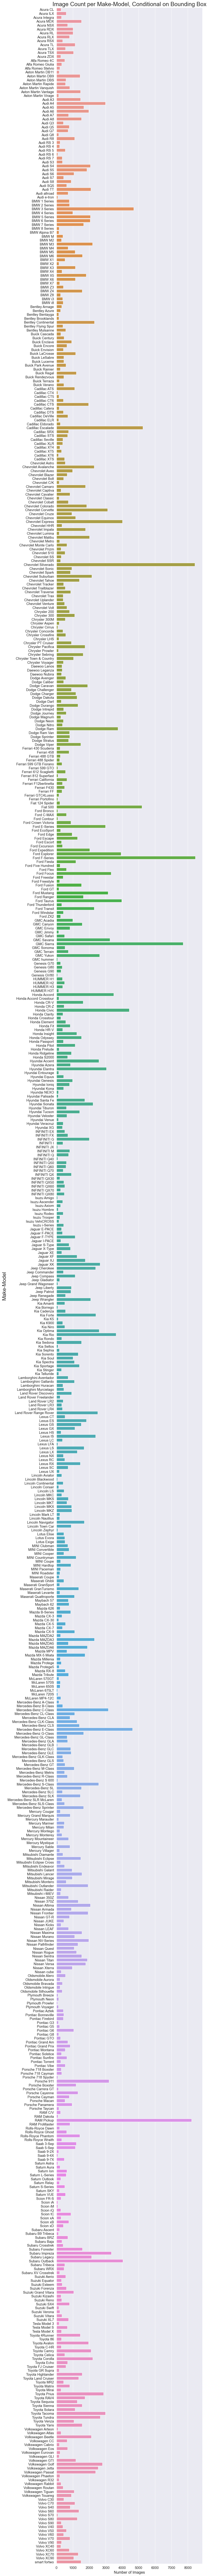

In [19]:
figure(figsize=(10, 180), dpi=80)
sns.set(font_scale=1.2)
sns.barplot(data=make_model_reduced, x='Count', y='Make_Model')
plt.xlabel("Number of Images")
plt.ylabel("Make-Model", fontsize=20)
plt.title("Image Count per Make-Model, Conditional on Bounding Box", fontsize=22)
plt.show()

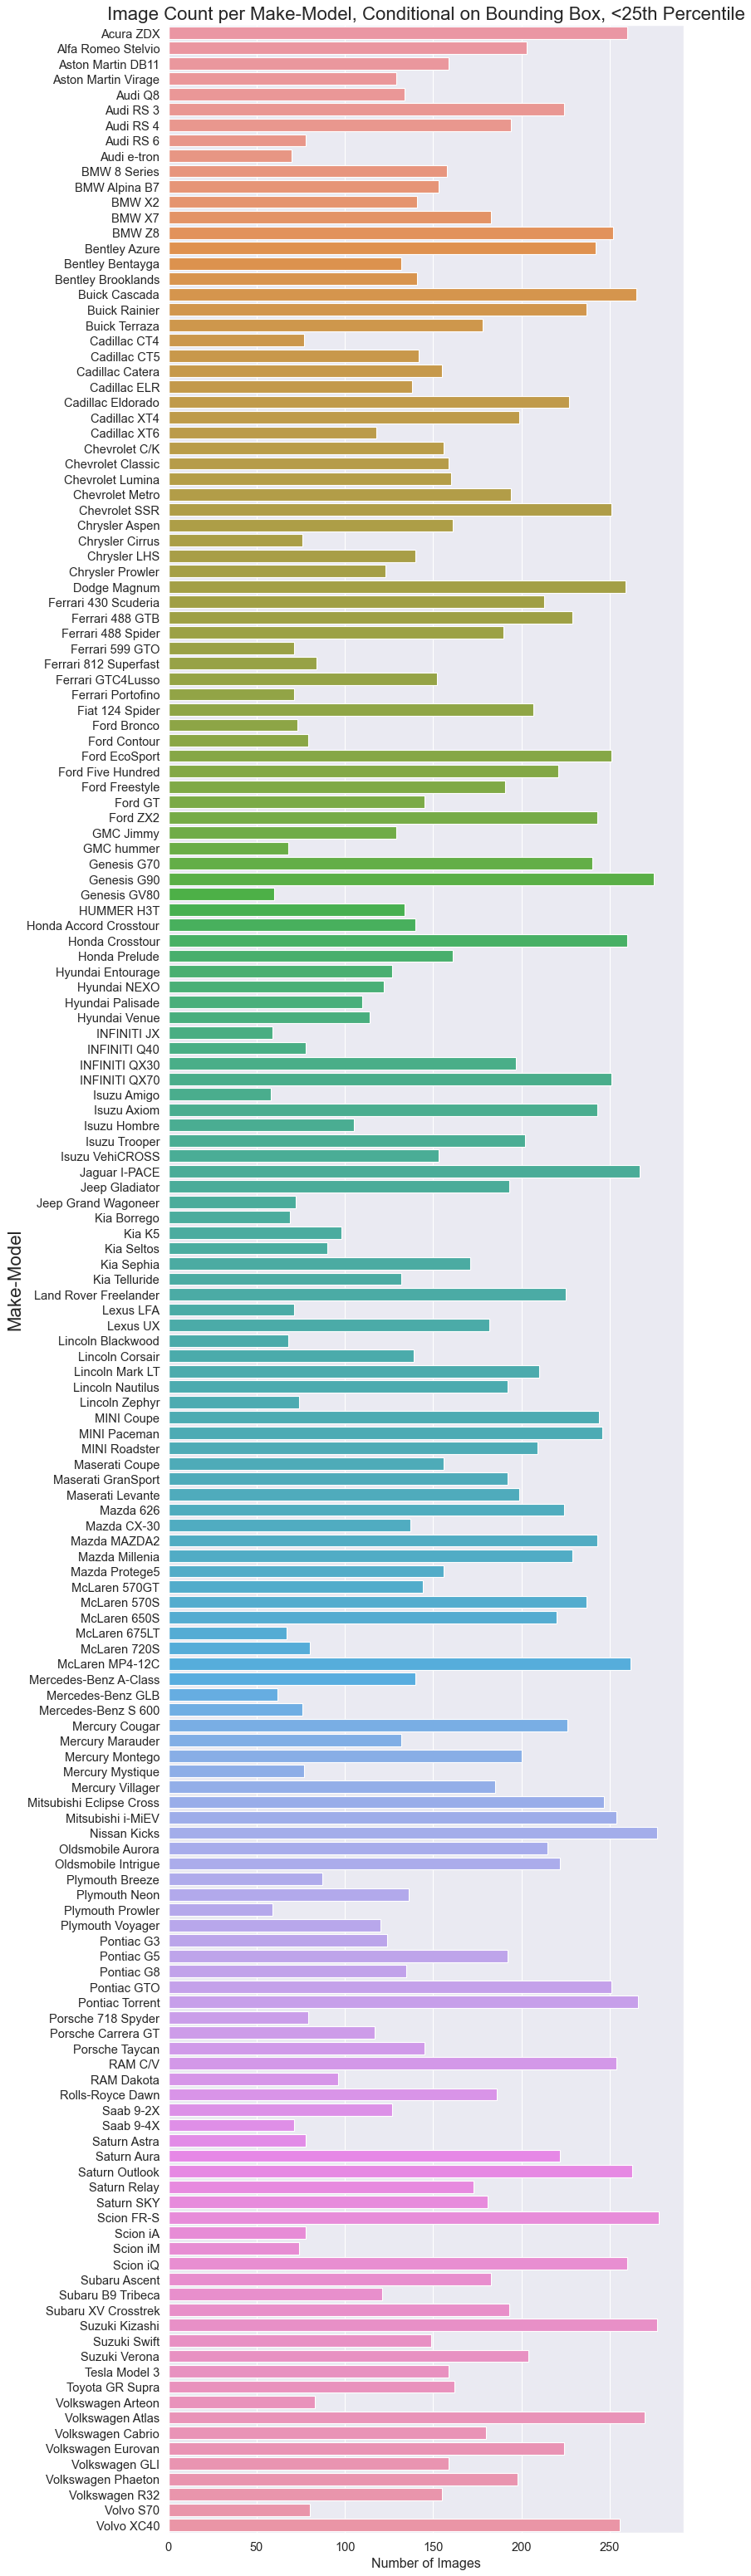

In [20]:
figure(figsize=(10, 50), dpi=80)
sns.set(font_scale=1.2)
sns.barplot(data=make_model_reduced.loc[make_model_reduced['Count'] < 280], x='Count', y='Make_Model')
plt.xlabel("Number of Images")
plt.ylabel("Make-Model", fontsize=20)
plt.title("Image Count per Make-Model, Conditional on Bounding Box, <25th Percentile", fontsize=20)
plt.show()